In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# Load the dataset
file_path = 'training_data.csv'
df = pd.read_csv(file_path)

print("--- 1. Data Cleaning and Preprocessing ---")

# Drop the 'ID' column as it's not a predictive feature
df = df.drop('ID', axis=1)

# Define features (X) and the target variable (y)
X = df.drop('Risk', axis=1)
y = df['Risk']

# Identify categorical and numerical columns for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Simple data cleaning: fill missing values
for col in categorical_features:
    if X[col].isnull().sum() > 0:
        X[col].fillna('missing', inplace=True) # Fill with a placeholder

for col in numerical_features:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True) # Fill with the column's median

print("✅ Missing values handled.")

# Create a preprocessor to one-hot encode categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep numerical columns as they are
)

print("✅ Preprocessing steps are defined.")
print("-" * 40)


--- 1. Data Cleaning and Preprocessing ---
✅ Missing values handled.
✅ Preprocessing steps are defined.
----------------------------------------


C:\Users\Jared\AppData\Local\Temp\ipykernel_19628\3523719106.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna('missing', inplace=True) # Fill with a placeholder


In [3]:

print("--- 2. Splitting Data (80% Train, 20% Test) ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set contains {X_train.shape[0]} samples.")
print(f"Testing set contains {X_test.shape[0]} samples.")
print("-" * 40)

--- 2. Splitting Data (80% Train, 20% Test) ---
Training set contains 896 samples.
Testing set contains 224 samples.
----------------------------------------


In [4]:
print("--- 3. Training the Decision Tree Classifier ---")
# We create a pipeline to chain the preprocessing and the classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=5,             # Limits the complexity of the tree for readability
        min_samples_leaf=10,       # Ensures rules aren't too specific
        random_state=42
    ))
])

# Train the model on the training data
model_pipeline.fit(X_train, y_train)
print("✅ Model training complete.")
print("-" * 40)


--- 3. Training the Decision Tree Classifier ---
✅ Model training complete.
----------------------------------------


In [5]:
print("--- 4. Extracted Decision Rules ---")
# Get the correct feature names after one-hot encoding
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Generate and print the text-based rules from the trained tree
tree_rules = export_text(model_pipeline.named_steps['classifier'], feature_names=list(feature_names))
print("The model has learned the following IF-THEN rules:")
print(tree_rules)
print("-" * 40)


--- 4. Extracted Decision Rules ---
The model has learned the following IF-THEN rules:
|--- cat__Checking account_missing <= 0.50
|   |--- remainder__Duration <= 8.50
|   |   |--- remainder__Age <= 26.50
|   |   |   |--- class: bad
|   |   |--- remainder__Age >  26.50
|   |   |   |--- remainder__Job <= 2.50
|   |   |   |   |--- remainder__Age <= 35.50
|   |   |   |   |   |--- class: good
|   |   |   |   |--- remainder__Age >  35.50
|   |   |   |   |   |--- class: good
|   |   |   |--- remainder__Job >  2.50
|   |   |   |   |--- class: bad
|   |--- remainder__Duration >  8.50
|   |   |--- remainder__Duration <= 43.50
|   |   |   |--- cat__Checking account_little <= 0.50
|   |   |   |   |--- cat__Saving accounts_missing <= 0.50
|   |   |   |   |   |--- class: bad
|   |   |   |   |--- cat__Saving accounts_missing >  0.50
|   |   |   |   |   |--- class: good
|   |   |   |--- cat__Checking account_little >  0.50
|   |   |   |   |--- remainder__Job <= 2.50
|   |   |   |   |   |--- class: bad

--- 5. Visualizing Model Performance ---
Overall Model Accuracy: 67.41%



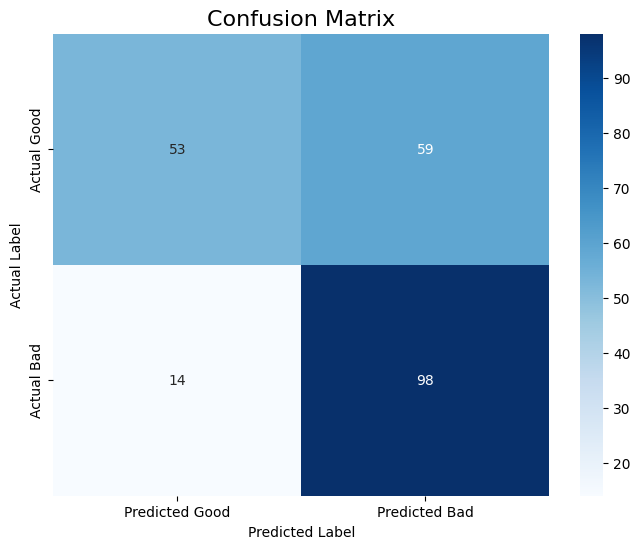

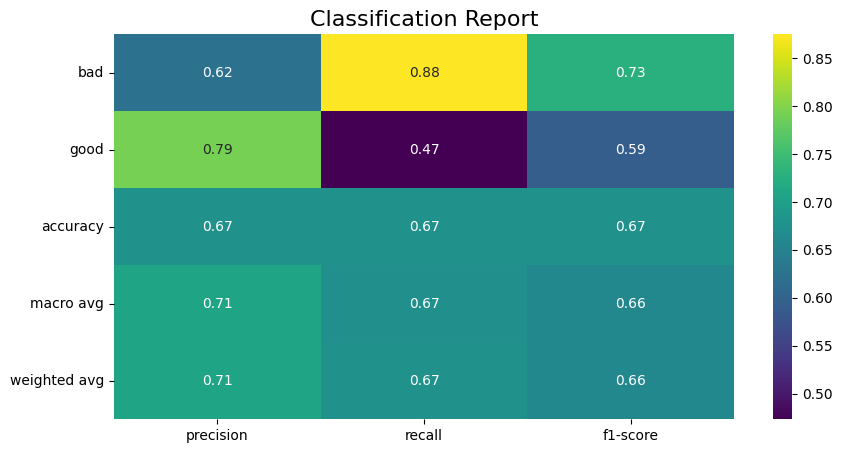


📊 Visualizations complete. The plots above summarize the model's performance.


In [6]:
# --- 5. Results Presentation with Seaborn ---

print("--- 5. Visualizing Model Performance ---")

# Make predictions on the unseen test data
y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Model Accuracy: {accuracy:.2%}\n")

# a) Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred, labels=['good', 'bad'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Good', 'Predicted Bad'],
            yticklabels=['Actual Good', 'Actual Bad'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# b) Classification Report as a Heatmap
report = classification_report(y_test, y_pred, output_dict=True)
# Convert the report to a DataFrame and drop unnecessary rows
report_df = pd.DataFrame(report).iloc[:-1, :].T

plt.figure(figsize=(10, 5))
sns.heatmap(report_df, annot=True, cmap='viridis', fmt='.2f')
plt.title('Classification Report', fontsize=16)
plt.show()

print("\n📊 Visualizations complete. The plots above summarize the model's performance.")